# EFN Regression Demo
An demo involving Energy Flow Networks (EFNs), which were introduced
in [1810.05165](https://arxiv.org/abs/1810.05165), to regress the jet
constituents to the jet mass. The [`EFN`](https://energyflow.network/docs/archs/#efn) class is used
to construct the network architecture. The output of the example is a plot of
the predicted and actual mass distributions.

In [1]:
# standard library imports
from __future__ import absolute_import, division, print_function

# fundamental python package imports
import numpy as np
import matplotlib.pyplot as plt

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN

In [2]:
################################### SETTINGS ##################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
output_act, output_dim = 'linear', 1
loss = 'mse'

# network training parameters
num_epoch = 5
batch_size = 250

## Prepare Datasets

In [3]:
# load data
X, y = ef.qg_jets.load(train + val + test)

# ignore pid information
X = X[:,:,:3]

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
event_mask = []
for x in X:
    mask = x[:,0] > 0
    event_mask.append(np.count_nonzero(mask) > 1)
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
X = X[np.asarray(event_mask)]

print('Finished preprocessing')

# compute the jet "mass" as an angularity with exponent 2
# it's easier for the network to predict the log of the observable, shifted and scaled
obs = np.log10(np.asarray([np.sum(x[:,0]*(x[:,1:3]**2).sum(1))/x[:,0].sum() for x in X]))
obs_mean, obs_std = np.mean(obs), np.std(obs)
obs -= obs_mean
obs /= obs_std

print('Finished computing observables')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 y_train, y_val, y_test) = ef.utils.data_split(X[:,:,0], X[:,:,1:], obs, val=val, test=test)

print('Done train/val/test split')

Loaded quark and gluon jets
Finished preprocessing
Finished computing observables
Done train/val/test split


## Build Model

In [4]:
# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          output_act=output_act, output_dim=output_dim, loss=loss, metrics=[])

# train model
efn.fit([z_train, p_train], y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], y_val),
        verbose=1)

# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=1000)[:,0]*obs_std + obs_mean

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
phats_input (InputLayer)        [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    300         phats_input[0][0]                
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
_______________________________________________________________________________________

## Plots

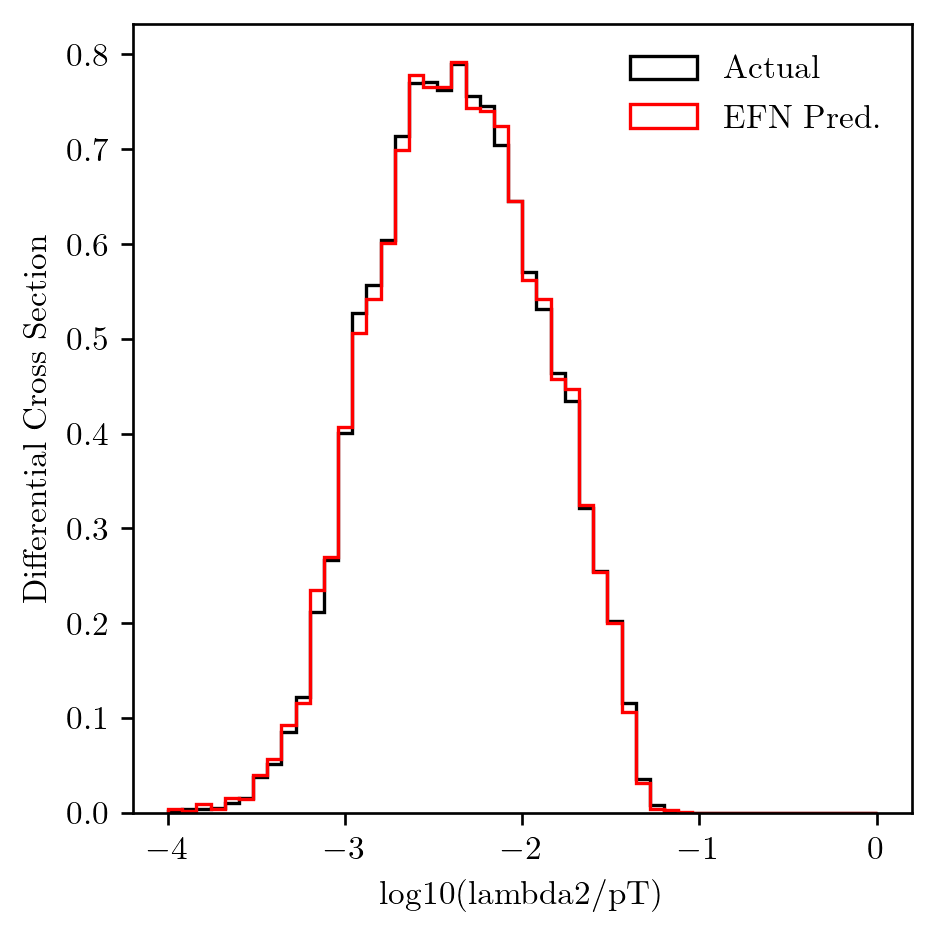

In [5]:
######################### Observable Distributions Plot #########################

# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
bins = np.linspace(-4, 0, 51)
obs_test = y_test*obs_std + obs_mean
plt.hist(obs_test, bins=bins, density=True, histtype='step', color='black', label='Actual')
plt.hist(preds, bins=bins, density=True, histtype='step', color='red', label='EFN Pred.')

# axes labels
plt.xlabel('log10(lambda2/pT)')
plt.ylabel('Differential Cross Section')

# make legend and show plot
plt.legend(loc='upper right', frameon=False)

plt.show()

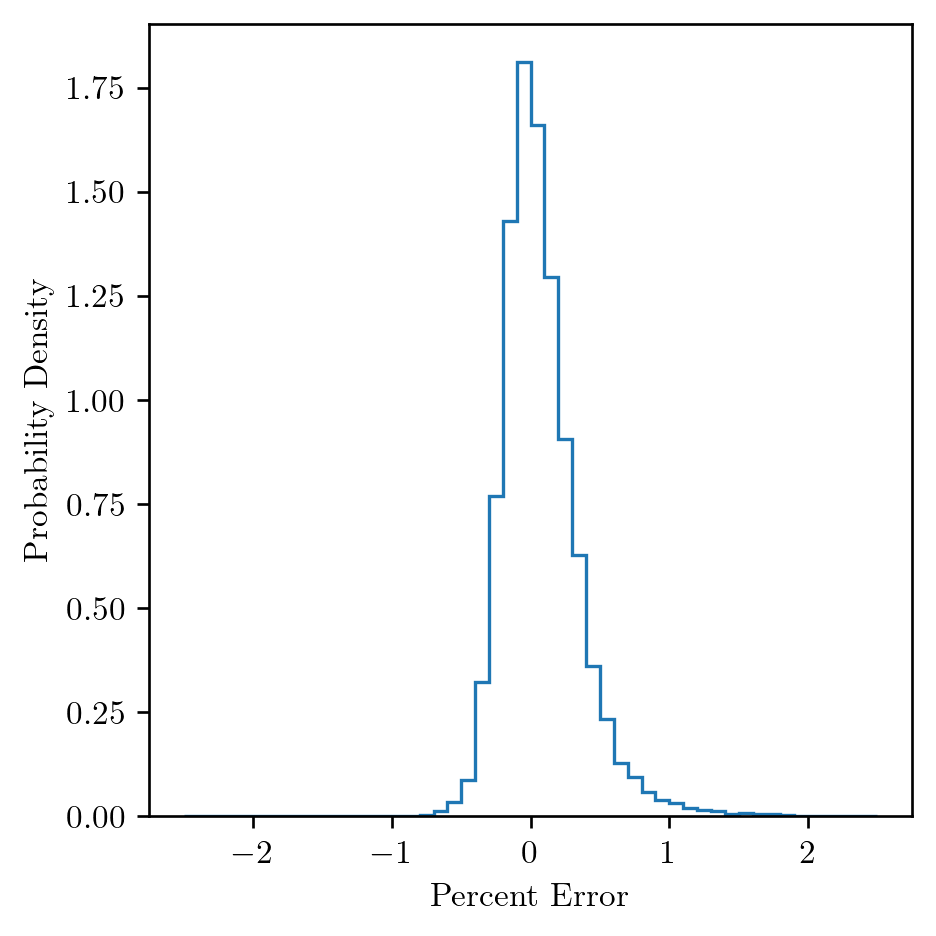

In [6]:
######################### Percent Error Plot #########################

plt.hist(2*(preds - obs_test)/(obs_test + preds)*100, bins=np.linspace(-2.5, 2.5, 51),
         histtype='step', density=True)
plt.xlabel('Percent Error')
plt.ylabel('Probability Density')
plt.show()

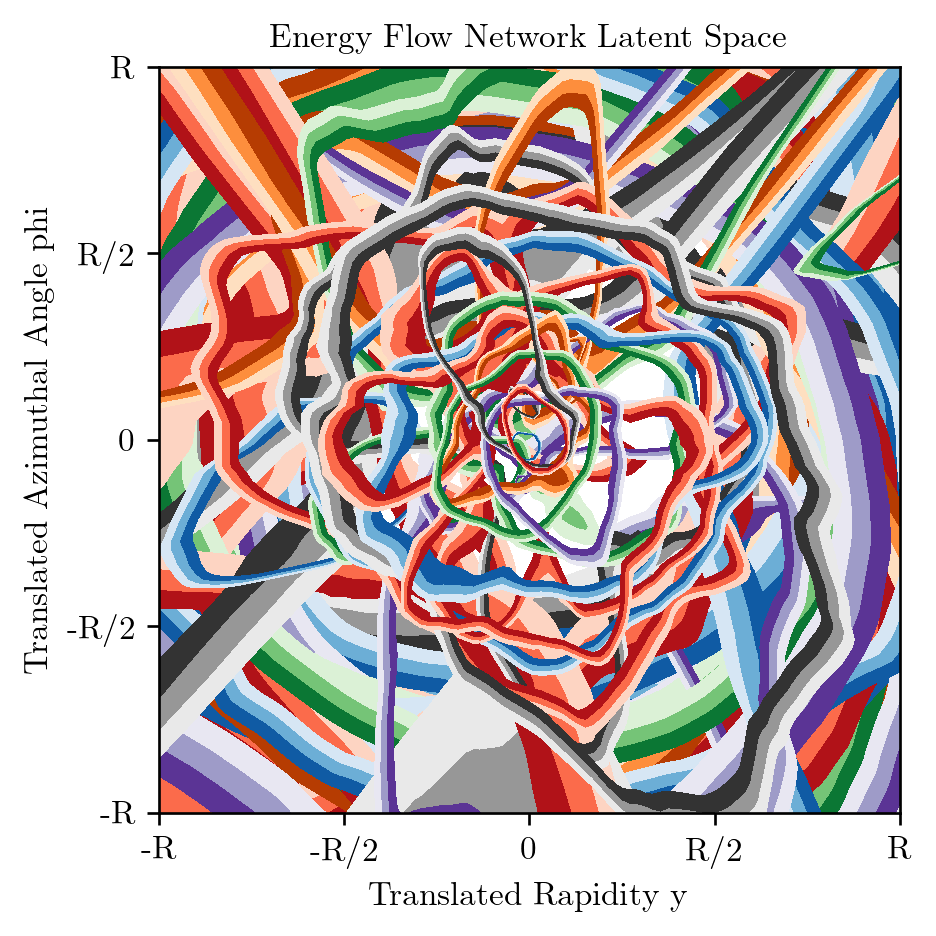

In [7]:
######################### EFN Latent Space #########################

# plot settings
R, n = 0.4, 100
colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
grads = np.linspace(0.45, 0.55, 4)

# evaluate filters
X, Y, Z = efn.eval_filters(R, n=n)

# for sorting filters according to position
def get_filter_size_and_position(filt, zfrac=0.5):   
    filt /= np.max(filt)
    maxind = np.argmax(filt)
    j, k = maxind//n, maxind%n
    
    angle = np.sqrt((j-n/2)**2 + (k-n/2)**2)*2/n
    size = np.count_nonzero(filt > zfrac)/n**2
    
    return size, angle

sizes, angles = [], []
for z in Z:
    size, angle = get_filter_size_and_position(z)
    sizes.append(size)
    angles.append(angle)
qg_sizes, qg_angles = np.asarray(sizes), np.asarray(angles)

# plot filters
for i,z in enumerate(Z[np.argsort(qg_angles)[::-1]]):
    plt.contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])

plt.xticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
plt.xlabel('Translated Rapidity y')
plt.ylabel('Translated Azimuthal Angle phi')
plt.title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})

plt.show()